In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("flight_delay.csv")


In [2]:
# Fill missing values
delay_cols = ['arr_delay', 'carrier_delay', 'weather_delay', 
              'nas_delay', 'security_delay', 'late_aircraft_delay']
df[delay_cols] = df[delay_cols].fillna(0)

count_cols = ['arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 
              'nas_ct', 'security_ct', 'late_aircraft_ct', 
              'arr_cancelled', 'arr_diverted']
df[count_cols] = df[count_cols].fillna(0)

# Feature engineering
df['delay_ratio'] = df['arr_del15'] / df['arr_flights']
df['cancel_ratio'] = df['arr_cancelled'] / df['arr_flights']
df['divert_ratio'] = df['arr_diverted'] / df['arr_flights']
df['avg_delay_per_flight'] = df['arr_delay'] / df['arr_flights']

df[['delay_ratio','cancel_ratio','divert_ratio','avg_delay_per_flight']] = \
df[['delay_ratio','cancel_ratio','divert_ratio','avg_delay_per_flight']].fillna(0)

# Encode categorical
le = LabelEncoder()
df['carrier_name_encoded'] = le.fit_transform(df['carrier_name'])
df['airport_name_encoded'] = le.fit_transform(df['airport_name'])


In [3]:
# Classification target (delay yes/no)
df['delay_label'] = np.where(df['delay_ratio'] > 0.15, 1, 0)

# Features
features = ['arr_flights', 'carrier_ct', 'weather_ct', 'nas_ct',
            'security_ct', 'late_aircraft_ct',
            'cancel_ratio', 'divert_ratio',
            'carrier_name_encoded', 'airport_name_encoded']

X = df[features]
y_class = df['delay_label']
y_reg = df['avg_delay_per_flight']


In [4]:
X_train, X_test, y_class_train, y_class_test, y_reg_train, y_reg_test = train_test_split(
    X, y_class, y_reg, test_size=0.2, random_state=42
)


In [5]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_class_train)

y_class_pred = clf.predict(X_test)
print("Classification Accuracy:", accuracy_score(y_class_test, y_class_pred))
print(classification_report(y_class_test, y_class_pred))


Classification Accuracy: 0.9698549542727326
              precision    recall  f1-score   support

           0       0.98      0.95      0.96     14151
           1       0.96      0.99      0.97     20183

    accuracy                           0.97     34334
   macro avg       0.97      0.97      0.97     34334
weighted avg       0.97      0.97      0.97     34334



In [6]:
# Use only rows where delay_label == 1
delayed_mask = y_class_train == 1
reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(X_train[delayed_mask], y_reg_train[delayed_mask])

# Predict regression only for predicted delayed flights
delayed_mask_test = (y_class_pred == 1)
y_reg_pred = np.zeros_like(y_reg_test)

if delayed_mask_test.sum() > 0:
    y_reg_pred[delayed_mask_test] = reg.predict(X_test[delayed_mask_test])

# Evaluate regression
mse = mean_squared_error(y_reg_test[delayed_mask_test], y_reg_pred[delayed_mask_test])
print("Regression RMSE (on delayed flights):", np.sqrt(mse))


Regression RMSE (on delayed flights): 7.52515763144147


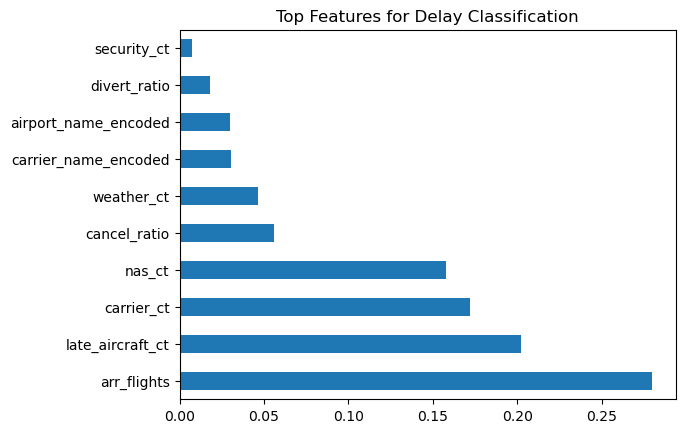

In [7]:
feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Top Features for Delay Classification")
plt.show()


In [9]:
import gradio as gr
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# -------------------------
# Load & preprocess dataset
# -------------------------
df = pd.read_csv("flight_delay.csv")

# Fill missing values
delay_cols = ['arr_delay', 'carrier_delay', 'weather_delay', 
              'nas_delay', 'security_delay', 'late_aircraft_delay']
df[delay_cols] = df[delay_cols].fillna(0)

count_cols = ['arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 
              'nas_ct', 'security_ct', 'late_aircraft_ct', 
              'arr_cancelled', 'arr_diverted']
df[count_cols] = df[count_cols].fillna(0)

# Feature engineering
df['delay_ratio'] = df['arr_del15'] / df['arr_flights']
df['cancel_ratio'] = df['arr_cancelled'] / df['arr_flights']
df['divert_ratio'] = df['arr_diverted'] / df['arr_flights']
df['avg_delay_per_flight'] = df['arr_delay'] / df['arr_flights']
df[['delay_ratio','cancel_ratio','divert_ratio','avg_delay_per_flight']] = \
df[['delay_ratio','cancel_ratio','divert_ratio','avg_delay_per_flight']].fillna(0)

# Encode categorical
le_carrier = LabelEncoder()
df['carrier_name_encoded'] = le_carrier.fit_transform(df['carrier_name'])

le_airport = LabelEncoder()
df['airport_name_encoded'] = le_airport.fit_transform(df['airport_name'])

# Define targets
df['delay_label'] = np.where(df['delay_ratio'] > 0.15, 1, 0)

features = ['arr_flights', 'carrier_ct', 'weather_ct', 'nas_ct',
            'security_ct', 'late_aircraft_ct',
            'cancel_ratio', 'divert_ratio',
            'carrier_name_encoded', 'airport_name_encoded']

X = df[features]
y_class = df['delay_label']
y_reg = df['avg_delay_per_flight']

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_class_train, y_class_test, y_reg_train, y_reg_test = train_test_split(
    X, y_class, y_reg, test_size=0.2, random_state=42
)

# Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_class_train)

# Train regressor (only on delayed flights)
delayed_mask = y_class_train == 1
reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(X_train[delayed_mask], y_reg_train[delayed_mask])

# -------------------------
# Prediction Function
# -------------------------
def predict_delay(arr_flights, carrier_ct, weather_ct, nas_ct,
                  security_ct, late_aircraft_ct,
                  cancel_ratio, divert_ratio,
                  carrier_name, airport_name):

    # Encode categorical
    carrier_enc = le_carrier.transform([carrier_name])[0] if carrier_name in le_carrier.classes_ else 0
    airport_enc = le_airport.transform([airport_name])[0] if airport_name in le_airport.classes_ else 0

    # Make input dataframe
    input_data = pd.DataFrame([[arr_flights, carrier_ct, weather_ct, nas_ct,
                                security_ct, late_aircraft_ct,
                                cancel_ratio, divert_ratio,
                                carrier_enc, airport_enc]],
                              columns=features)

    # Step 1: Classification
    delay_class = clf.predict(input_data)[0]

    if delay_class == 1:
        # Step 2: Regression
        delay_minutes = reg.predict(input_data)[0]
        return f"✅ Delay Likely: YES\n⏱ Expected Average Delay: {round(delay_minutes,2)} minutes"
    else:
        return "✅ Delay Likely: NO\n⏱ Expected Delay: 0 minutes"

# -------------------------
# Build Gradio Interface
# -------------------------
demo = gr.Interface(
    fn=predict_delay,
    inputs=[
        gr.Number(label="Number of Arriving Flights (arr_flights)", value=np.random.randint(50, 500)),
        gr.Number(label="Carrier Delay Count (carrier_ct)", value=np.random.randint(0, 50)),
        gr.Number(label="Weather Delay Count (weather_ct)", value=np.random.randint(0, 30)),
        gr.Number(label="NAS Delay Count (nas_ct)", value=np.random.randint(0, 40)),
        gr.Number(label="Security Delay Count (security_ct)", value=np.random.randint(0, 5)),
        gr.Number(label="Late Aircraft Delay Count (late_aircraft_ct)", value=np.random.randint(0, 50)),
        gr.Number(label="Cancel Ratio (0-1)", value=round(np.random.uniform(0, 0.2), 2)),
        gr.Number(label="Divert Ratio (0-1)", value=round(np.random.uniform(0, 0.1), 2)),
        gr.Dropdown(choices=list(le_carrier.classes_), label="Carrier Name", value=list(le_carrier.classes_)[0]),
        gr.Dropdown(choices=list(le_airport.classes_), label="Airport Name", value=list(le_airport.classes_)[0]),
    ],
    outputs="text",
    title="✈️ Airline Delay Predictor",
    description=(
        "Predict if flights will be delayed and estimate average delay minutes.\n\n"
        "👉 Example Input:\n"
        "- Flights: 200\n"
        "- Carrier Delay Count: 12\n"
        "- Weather Delay Count: 5\n"
        "- NAS Delay Count: 8\n"
        "- Cancel Ratio: 0.05\n"
        "- Divert Ratio: 0.01\n"
        "- Carrier: American Airlines\n"
        "- Airport: Atlanta Hartsfield"
    )
)

demo.launch()


* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


Using existing dataset file at: .gradio\flagged\dataset1.csv
